In [27]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.simulation import Simulation
from optimization import Optimization
from structures import three_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
lambda0 = 2e-6
c0 = 3e8
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi)
dl = 0.4e-1                   # grid size (L0)
Nx = 200
Ny = 160
nx, ny = int(Nx/2), int(Ny/2)
shape = (Nx,Ny)           # shape of domain (in grids)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [29]:
# define the two port parameters
L = 3
H = 3
w = .2
d = 1.5
# d = int(d/2/dl)*dl*2
eps_m = 5
spc = 1
l = 2

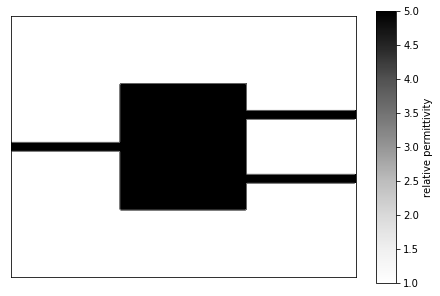

In [30]:
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, l, spc, NPML, eps_start=5)
simulation = Simulation(omega,eps_r,dl,NPML,pol)
simulation.plt_eps()
plt.show()

In [31]:
eps = simulation.eps_r
pts_in = np.sum(eps[30,:] > 1)
pts_top = np.sum(eps[Nx-30,:ny] > 1)
pts_bot = np.sum(eps[Nx-30,ny:] > 1)

print('waveguide has {} points in in port'.format(pts_in))
print('waveguide has {} points in top port'.format(pts_top))
print('waveguide has {} points in bottom port'.format(pts_bot))


waveguide has 5 points in in port
waveguide has 5 points in top port
waveguide has 5 points in bottom port


In [32]:
# set the modal source and probes

# simulation to solve
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=70)
simulation.setup_modes()
print('input power of {} W/L0'.format(simulation.W_in))
# top modal profile (kind of a hack, could be nice to get this without making a simulation())
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(3.5, 'x', [Nx-30, ny+int(d/2/dl)], int(d/dl))
top.setup_modes()
J_top = np.abs(top.src)  # sometimes negative and sometimes positive. So I just abs it for consistency

# bottom modal profile
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(3.5, 'x', [Nx-30, ny-int(d/2/dl)], int(d/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

input power of 9.868405170262461 W/L0


In [33]:
# set source and solve for electromagnetic fields
print('{} grids per wavelength'.format(int(lambda0/dl/1e-6)))
(Hx,Hy,Ez) = simulation.solve_fields()

50 grids per wavelength


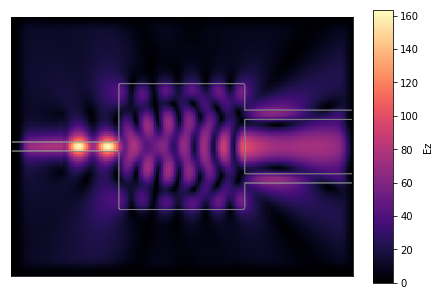

In [34]:
# plot linear field
simulation.plt_abs(outline=True, cbar=True);

In [35]:
# Define some parameters for the optimization
eps_max = 5
Nsteps = 100
Jregion = np.zeros(eps_r.shape)
Jregion[Nx-15, ny+int(d/2/dl)] = 1
Jregion_nl = np.zeros(eps_r.shape)
Jregion_nl[Nx-15, ny-int(d/2/dl)] = 1
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2

In [57]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_top)
J['nonlinear'] = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_bot)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e, eps_r: np.conj(e)*J_top
dJdE['nonlinear'] = lambda e, eps_r: np.conj(e)*J_bot
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin + dJdE_nonlin

# define linear and nonlinear parts of dJdeps + the total derivative form
dJdeps_explicit = {}
dJdeps_explicit ['linear']    = lambda e, eps_r: 0
dJdeps_explicit ['nonlinear'] = lambda e, eps_r: 0
dJdeps_explicit ['total']     = lambda dJdeps_lin, dJdeps_nonlin: dJdeps_lin + dJdeps_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity     = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.square(np.abs(e))
kerr_nl_de            = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.conj(e)*((eps_r-1)
kerr_nl_deps          = lambda e, eps_r: 3*chi3/np.square(simulation.L0)*np.square(np.abs(e))
nonlin_fns = {}
nonlin_fns['eps_nl']   = kerr_nonlinearity
nonlin_fns['dnl_de']   = kerr_nl_de
nonlin_fns['dnl_deps'] = kerr_nl_deps

SyntaxError: invalid syntax (<ipython-input-57-e255af55efa8>, line 30)

In [59]:
simulation.eps_r = eps_r

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=100, J=J, dJdE=dJdE, dJdeps_explicit=dJdeps_explicit, eps_max=5, step_size=.1, solver='newton', opt_method='adam')
(avm_grads, num_grads) = opt_both.check_deriv_lin(simulation, regions['design'])
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.linalg.norm(avm_grads[i] - num_grads[i]))

(avm_grads, num_grads) = opt_both.check_deriv_nonlin(simulation, regions, nonlin_fns)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.linalg.norm(avm_grads[i] - num_grads[i]))


4.716840455773466 4.716843322967179 2.867193713562699e-06
-0.4549184999432835 -0.4549197547021322 1.2547588487121786e-06
-6.097540571679053 -6.097543937357841 3.3656787881142236e-06
5.995310915855244 5.995313731546048 2.815690804069959e-06
-5.7739335441231345 -5.773941429652041 7.885528906292905e-06
-1.063772178747186 -1.0637733430485241 1.1643013380080447e-06
-2.754347297050905 -2.754352208285127 4.911234221971483e-06
-2.772090297201205 -2.7720952857634984 4.988562293473109e-06
-3.956318551427947 -3.956324017053703 5.46562575598486e-06
-2.1319059418170916 -2.13191524380818 9.301991088506156e-06


100% (100 of 100) |######################| Elapsed Time: 0:07:40 ETA:  00:00:00

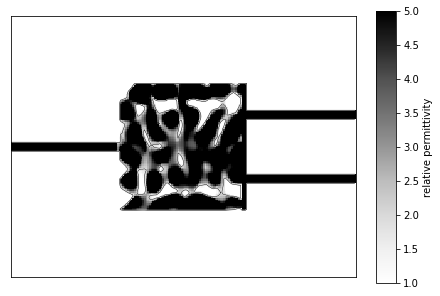

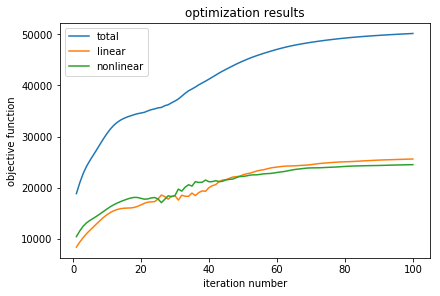

In [60]:
# run that optimization with the simulation and your objective function stuff
(new_eps_1) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)
simulation.plt_eps()
plt.show()
opt_both.plt_objs()
plt.show()

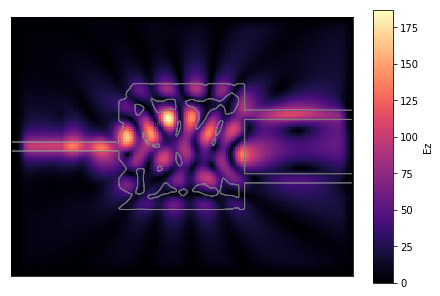

In [44]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()

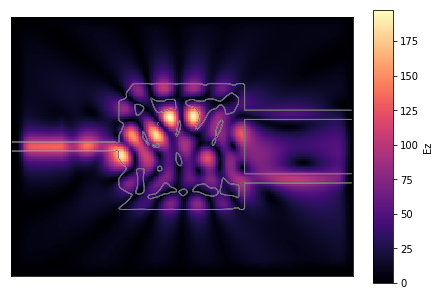

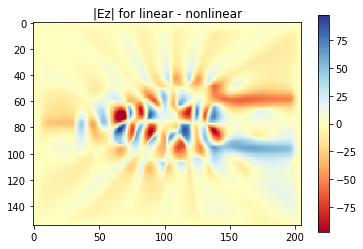

In [45]:
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

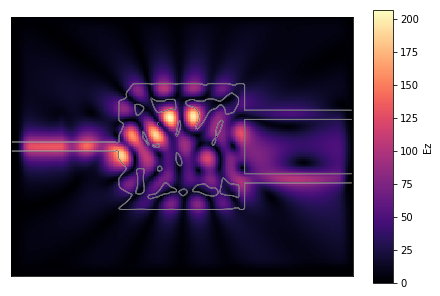

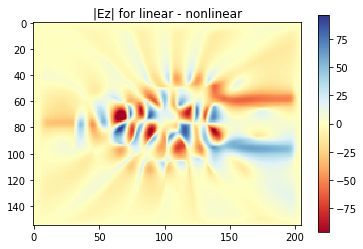

In [46]:
# compare the nonlinear and linear fields when we scale the nonlinearity
kerr_nonlinearity     = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*((eps_r-1)/(eps_max - 1))
kerr_nl_de            = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.conj(e)*((eps_r-1)/(eps_max - 1))
nonlin_fns['eps_nl'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

In [49]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_top)
J['nonlinear'] = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_bot)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e, eps_r: np.conj(e)*J_top
dJdE['nonlinear'] = lambda e, eps_r: np.conj(e)*J_bot
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin + dJdE_nonlin

# define linear and nonlinear parts of dJdeps + the total derivative form
dJdeps_explicit = {}
dJdeps_explicit ['linear']    = lambda e, eps_r: 0
dJdeps_explicit ['nonlinear'] = lambda e, eps_r: 0
dJdeps_explicit ['total']     = lambda dJdeps_lin, dJdeps_nonlin: dJdeps_lin + dJdeps_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity     = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*((eps_r-1)/(eps_max - 1))
kerr_nl_de            = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.conj(e)*((eps_r-1)/(eps_max - 1))
kerr_nl_deps          = lambda e, eps_r: 3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*(1/(eps_max - 1))
nonlin_fns = {}
nonlin_fns['eps_nl']   = kerr_nonlinearity
nonlin_fns['dnl_de']   = kerr_nl_de
nonlin_fns['dnl_deps'] = kerr_nl_deps

In [54]:
simulation.eps_r = eps_r

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=100, J=J, dJdE=dJdE, dJdeps_explicit=dJdeps_explicit, eps_max=5, step_size=.1, solver='newton', opt_method='adam')
(avm_grads, num_grads) = opt_both.check_deriv_lin(simulation, regions['design'])
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.linalg.norm(avm_grads[i] - num_grads[i]))

(avm_grads, num_grads) = opt_both.check_deriv_nonlin(simulation, regions, nonlin_fns)
for i in range(len(avm_grads)):
    print(avm_grads[i], num_grads[i], np.linalg.norm(avm_grads[i] - num_grads[i]))

3.27345167634609 3.273454185546143 2.509200053069094e-06
-3.586669374685046 -3.586674683901947 5.3092169007840084e-06
-2.47432468163157 -2.4743280482653063 3.366633736234803e-06
3.3310943104448945 3.3310936305497307 6.798951637243533e-07
-5.068889173755378 -5.068896516604582 7.34284920422823e-06
2.011236566876639 2.011242067965213 5.5010885740003346e-06
-1.317820045690084 -1.3178212793718558 1.23368177185057e-06
7.027499361014668 7.0275054895319045 6.128517236803077e-06
17.04913342967807 17.049147045327118 1.3615649049114609e-05
1.525095301034494 1.5250959768309258 6.757964317039011e-07


100% (100 of 100) |######################| Elapsed Time: 0:07:45 ETA:  00:00:00

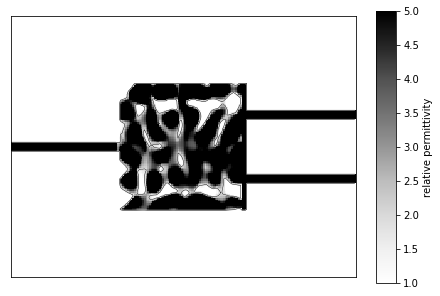

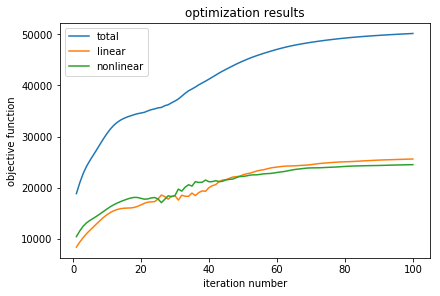

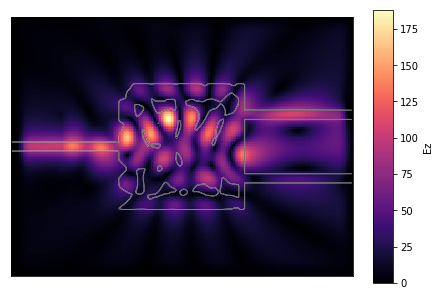

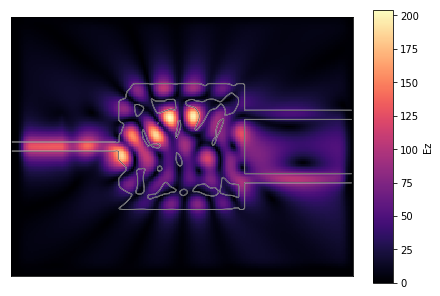

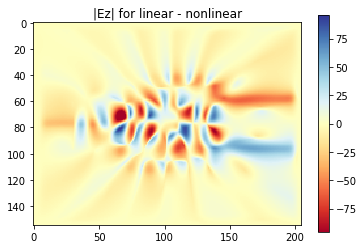

In [56]:
# run that optimization with the simulation and your objective function stuff
(new_eps) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)
simulation.plt_eps()
plt.show()
opt_both.plt_objs()
plt.show()

# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

In [61]:
print(np.linalg.norm(new_eps - new_eps_1))

0.0


In [ ]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_top)
J['nonlinear'] = lambda e, eps_r: np.sum(np.square(np.abs(e))*J_bot)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e, eps_r: np.conj(e)*J_top
dJdE['nonlinear'] = lambda e, eps_r: np.conj(e)*J_bot
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin + dJdE_nonlin

# define linear and nonlinear parts of dJdeps + the total derivative form
dJdeps_explicit = {}
dJdeps_explicit ['linear']    = lambda e, eps_r: 0
dJdeps_explicit ['nonlinear'] = lambda e, eps_r: 0
dJdeps_explicit ['total']     = lambda dJdeps_lin, dJdeps_nonlin: dJdeps_lin + dJdeps_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity     = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*((eps_r-1)/(eps_max - 1))
kerr_nl_de            = lambda e, eps_r:3*chi3/np.square(simulation.L0)*np.conj(e)*((eps_r-1)/(eps_max - 1))
kerr_nl_deps          = lambda e, eps_r: 3*chi3/np.square(simulation.L0)*np.square(np.abs(e))*(1/(eps_max - 1))
nonlin_fns = {}
nonlin_fns['eps_nl']   = kerr_nonlinearity
nonlin_fns['dnl_de']   = kerr_nl_de
nonlin_fns['dnl_deps'] = kerr_nl_deps